# Time Series Modeling and Forecasting with ARIMA

In [1]:
# machinelearningplus.com
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.arima_model import ARIMA
from dateutil.parser import parse
import pandas as pd
import pandas_datareader.data as web
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
import datetime as dt
import ta
from scipy import signal
from pmdarima.arima.utils import ndiffs

/Applications/anaconda3/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# import stock data from yahoo
start = dt.datetime(2000,1,1)
end = dt.datetime(2020,2,12)

#load data from yahoo
df = web.DataReader('MSFT', 'yahoo', start, end)

In [3]:
# Seasonal Plot of Stock Price
df.reset_index(inplace=True)
df['year'] = [d.year for d in df.Date]
df['month'] = [d.strftime('%b') for d in df.Date]
years = df['year'].unique()

In [4]:
np.random.seed(100)
colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

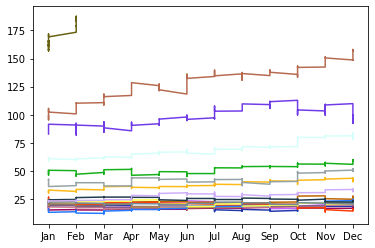

In [5]:
plt.figure()
for i, y in enumerate(years):
    if i > 0:
        plt.plot('month', 'Adj Close', data=df.loc[df.year==y, :], color=colors[i], label=y)
        #plt.text(df.loc[df.year==y, :].shape[0]-100, df.loc[df.year==y, 'Adj Close'][-1:].values[0], y, fontsize=12, color=colors[i])
        

plt.show()
    

In [6]:
# trend and seasonality
#multiplicative decomposition

# this doesn't seem to work for stock data bc there is no inferred frequency
# result_mul = seasonal_decompose(df['Adj Close'].loc[df.year==2019], model='multiplicative',
#                                extrapolate_trend='freq')

# result_mul = seasonal_decompose(df['Adj Close'].loc[df.year==2019], model='additive',
#                                extrapolate_trend='freq')

# perhaps another way this might be done is by trying to find the frequency
# of a technical indicator like the RSI
# or maybe look into another stock that is in a more cyclical industry

In [7]:
# trying to find trend and seasonality of RSI

# RSI
indicator_rsi = ta.momentum.RSIIndicator(close=df["Adj Close"], fillna=True)
df['rsi'] = indicator_rsi.rsi()

# MACD
macd = ta.trend.MACD(close=df['Adj Close'], fillna=True)
df['MACD_diff'] = macd.macd_diff()

# 200 day SMA
indicator_sma = ta.trend.SMAIndicator(close=df["Adj Close"], n=200, fillna=True)
df['sma_200'] = indicator_sma.sma_indicator()
df['sma_200_sig'] = (df['Adj Close'] > df['sma_200']).astype(int)

# 100 day SMA
indicator_sma = ta.trend.SMAIndicator(close=df["Adj Close"], n=100, fillna=True)
df['sma_100'] = indicator_sma.sma_indicator()
df['sma_100_sig'] = (df['Adj Close'] > df['sma_100']).astype(int)

# 50 day SMA
indicator_sma = ta.trend.SMAIndicator(close=df["Adj Close"], n=50, fillna=True)
df['sma_50'] = indicator_sma.sma_indicator()
df['sma_50_sig'] = (df['Adj Close'] > df['sma_50']).astype(int)

# 21 day EMA
indicator_ema = ta.trend.EMAIndicator(close=df["Adj Close"], n=21, fillna=True)
df['ema_21'] = indicator_ema.ema_indicator()
df['ema_21_sig'] = (df['Adj Close'] > df['ema_21']).astype(int)

# 14 day EMA
indicator_ema = ta.trend.EMAIndicator(close=df["Adj Close"], n=14, fillna=True)
df['ema_14'] = indicator_ema.ema_indicator()
df['ema_14_sig'] = (df['Adj Close'] > df['ema_14']).astype(int)

# 7 day EMA
indicator_ema = ta.trend.EMAIndicator(close=df["Adj Close"], n=7, fillna=True)
df['ema_7'] = indicator_ema.ema_indicator()
df['ema_7_sig'] = (df['Adj Close'] > df['ema_7']).astype(int)

In [8]:
# this doesn't seem to work either - atleast for MSFT

# result_mul = seasonal_decompose(df['rsi'], model='additive',
#                                extrapolate_trend='freq')

# I tried to do the same for a few other stocks and none of them worked
# I tried stocks regarded as cylical, I tried 1, 10, and 20 year periods.
# I tried both RSI and adjusted close

# start = dt.datetime(2019,1,1)
# end = dt.datetime(2020,1,1)
# df = web.DataReader('MU', 'yahoo', start, end)
# df.reset_index(inplace=True)
# df['year'] = [d.year for d in df.Date]
# df['month'] = [d.strftime('%b') for d in df.Date]
# years = df['year'].unique()
# indicator_rsi = ta.momentum.RSIIndicator(close=df["Adj Close"], fillna=True)
# df['rsi'] = indicator_rsi.rsi()
# result_mul = seasonal_decompose(df['rsi'], model='additive',extrapolate_trend=1)

# Stationary and Non-stationary time series
A stationary series is one in which a shift in time will not change the distribution. The mean, variance and autocorrelation are constant over time. Autocorrelation is a measure of how the series is correlated with its previous values, or in other words, the correlation of a signal with a delayed copy of itself.

According to author, it is possible to make nearly any time series stationary by applying a suitable transformation. You can make a time series staionary by:

1. Differencing the the series once or more
2. Take the log of the series
3. Take the nth root of the series
4. Combination of above

Differencing the series is subtracting the next value by the current value.
Making a series stationary is helpful becuase autoregressive forecasting is essentially linear regression that utilizes the lag of the series itself as predictors. Linear regression works best if the inputs are not correlated - and stationarizing the series solves this problem.

One way to test for stationarity is by Unit Root Tests

# ADH Test: 
Null hypothesis is the time series possesses a unit root and is non-stationary. If the P-value is less than the significance level (0.05), you reject the null Hypothesis.

# KPSS Test
Used to test trend stationarity. The null hypothesis and p-value interpretation are the opposite of the ADH test.

In [9]:
# i wrote this function but you can use df.diff() to do this
def difference(series):
    series = list(series)
    for i in range(len(series)-1):
        series[i]=series[i+1]-series[i]
    series.pop()
    return series

s = np.array([1, 5, 2, 12, 20])
print(difference(s))

[4, -3, 10, 8]


In [10]:
# ADF Test
result = adfuller(df['Adj Close'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'{key}, {value}')
    
pval = result[1]
if pval < 0.05:
    print("Stationary")
else: print('Non-Stationary')
    
# ADF Test
result = adfuller(df['rsi'].values, autolag='AIC')
print('\nRSI')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critical Values:')
    print(f'{key}, {value}')
    
pval = result[1]
if pval < 0.05:
    print("Stationary")
else: print('Non-Stationary')

ADF Statistic: 8.034884614077638
p-value: 1.0
Critical Values:
1%, -3.431645313089645
Critical Values:
5%, -2.8621123895900364
Critical Values:
10%, -2.5670746834542664
Non-Stationary

RSI
ADF Statistic: -10.847979526613258
p-value: 1.5547376814556422e-19
Critical Values:
1%, -3.431646597248311
Critical Values:
5%, -2.8621129569268713
Critical Values:
10%, -2.567074985469393
Stationary


In [11]:
# ADF Test
result = kpss(df['Adj Close'].values, regression='c')
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[3].items():
    print('Critical Values:')
    print(f'{key}, {value}')

KPSS Statistic: 8.776226337783047
p-value: 0.01
Critical Values:
10%, 0.347
Critical Values:
5%, 0.463
Critical Values:
2.5%, 0.574
Critical Values:
1%, 0.739


/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


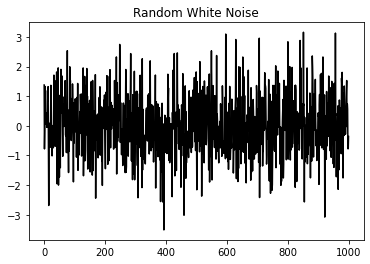

In [12]:
# white noise is completely random with 0 mean - there is no 
randvals = np.random.randn(1000)
pd.Series(randvals).plot(title='Random White Noise', color='k')
plt.show()

# Detrending a time series by either:
1. Subtract the line of best fit from the time series (linear or polynomial regression)
2. Subtract the trend component we saw from the stats library earlier
3. Subtract the Mean
4. Apply a filter like baxter-king or Hodrick-Prescott to remove the moving average trendlines or cyclical components

There are way to deseasonalize a time series, but I'm not particularly interested in these as I don't see them applying to stocks - perhaps commodities/metals could be an interesting place to investigate seasonality.

In [13]:
# # using scipy to detrend with line of best fit
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])
# detrended = signal.detrend(df.value.values)
# plt.plot(detrended)
# plt.title('Drug Sales detrended by subtracting the least squares fit', fontsize=16)
# plt.show()

In [14]:
# # using scipy to detrend with line of best fit
# # im not sure what this offers us in terms of making stock predictions, but at least the library doesn't fail
# df = web.DataReader('MSFT', 'yahoo', start, end)
# detrended = signal.detrend(df['Adj Close'].values)
# plt.plot(detrended)
# plt.title('Stock Price detrended by least squares', fontsize=16)
# plt.show()

In [15]:
# # Using statmodels: Subtracting the Trend Component.
# # we already know this will fail with stock data - this library doesn't like messy stock data
# from statsmodels.tsa.seasonal import seasonal_decompose
# df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
# result_mul = seasonal_decompose(df['value'], model='multiplicative', extrapolate_trend='freq')
# detrended = df.value.values - result_mul.trend
# plt.plot(detrended)
# plt.title('Drug Sales detrended by subtracting the trend component', fontsize=16)
# plt.show()

# Autocorrelation Function Plot
ACF plot can help show us if there is any seasonality, and the period(s) of it

Autocorrelation is the correlation of a time series with its lags. If a series is significantly autocorrelated, that means the previous values of the series may be helpful in predicting the current value. Partial Autocorrelation conveys the 'pure' correlation of a series and its lag, excluding the correlation of contributions from the intermediate lags. 

## How to compute the partial autocorrelation functions:
The partial autocorrelation of lag$[k]$ of a series is the coefficient of that lag in the autoregression equation of y. The autoregressive equation of Y is the linear regression of Y with its of lags as predictors. For example the partial autocorrelation of lag 3 is the coefficient $\alpha_3$ in the following:

$Y_t = \alpha_0+\alpha_1Y_{t-1}+\alpha_2Y_{t-2}+\alpha_3Y_{t-3}$

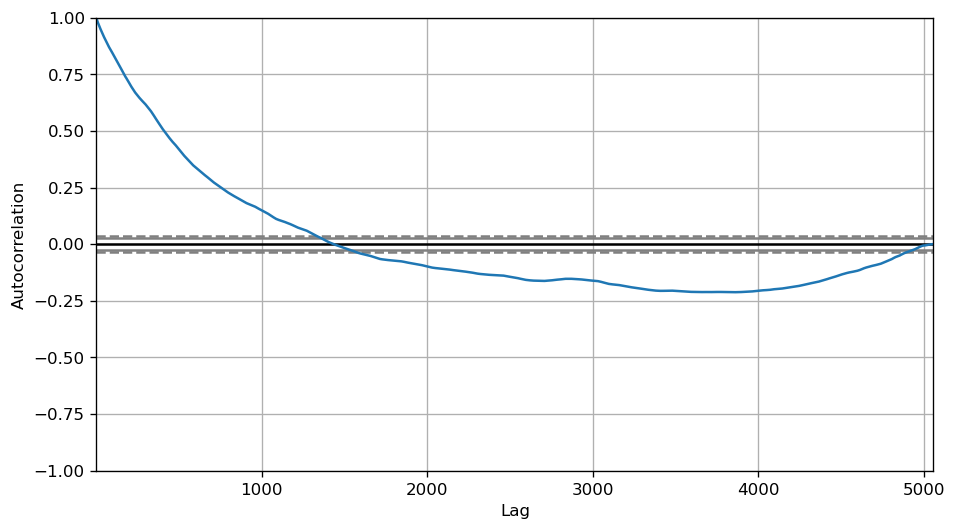

In [16]:
# Autocorrelation - for Adj. Close
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df['Adj Close'].tolist())

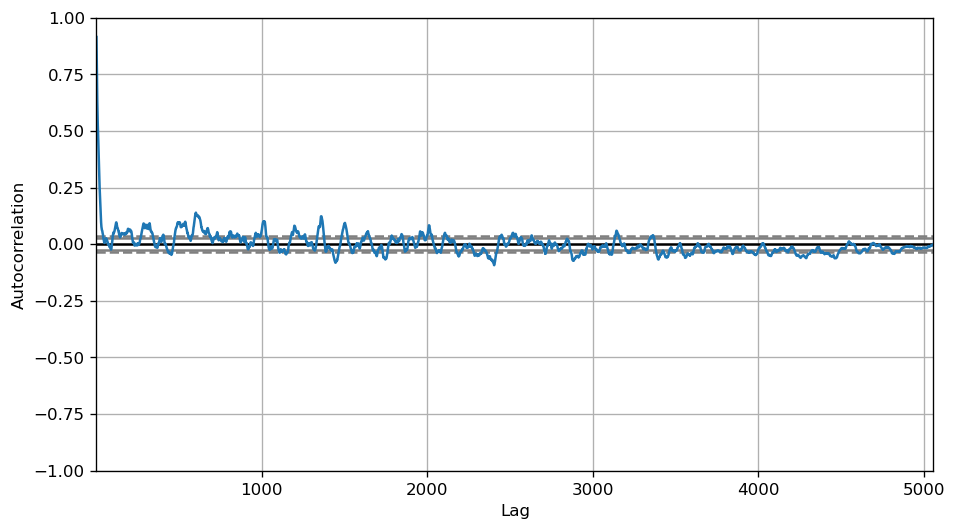

In [17]:
# Autocorrelation - for rsi
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df['rsi'].tolist())
plt.show()

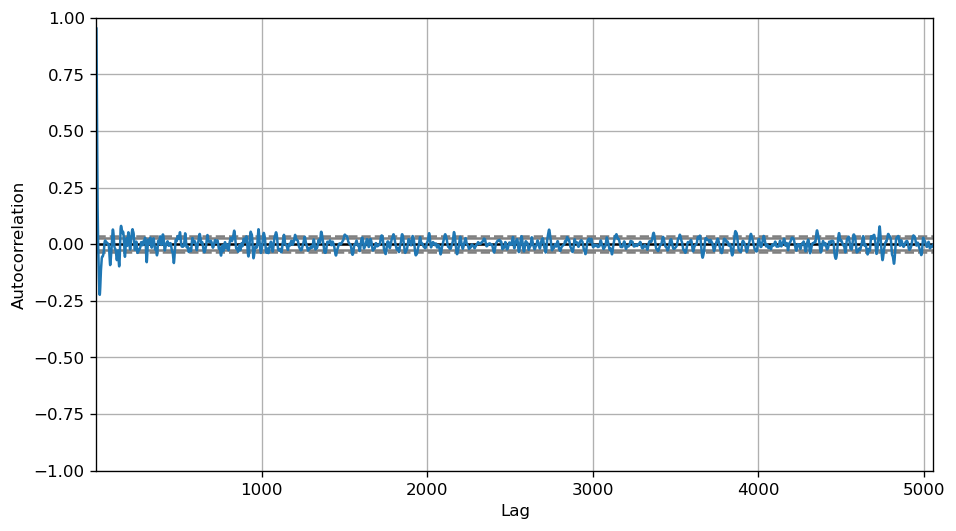

In [18]:
# Draw Plot - for macd
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df['MACD_diff'].tolist())
plt.show()

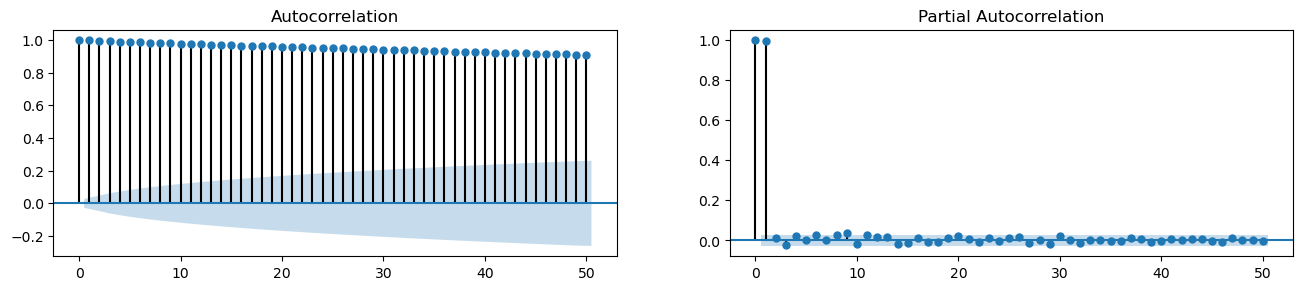

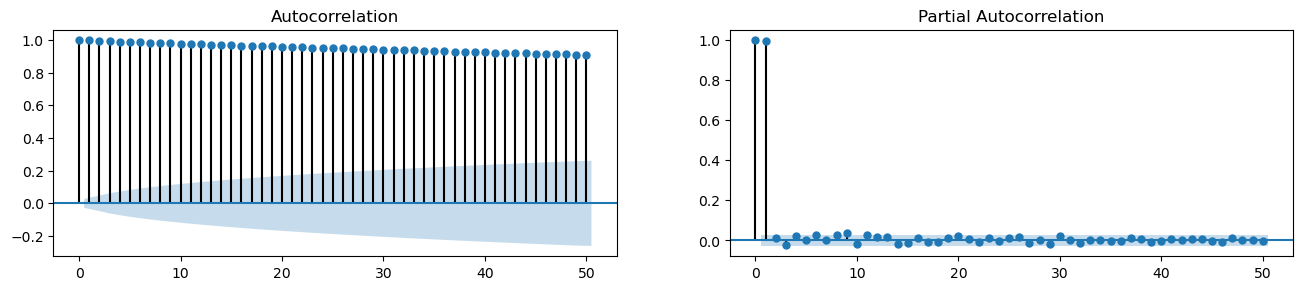

In [19]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['Adj Close'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['Adj Close'].tolist(), lags=50, ax=axes[1])

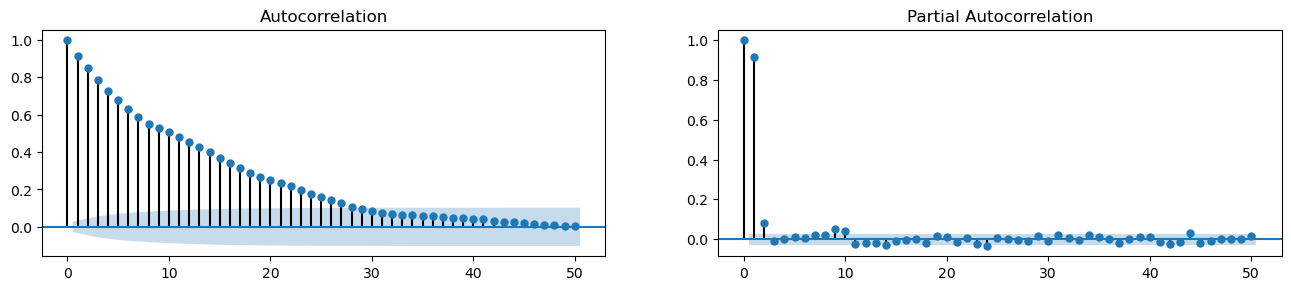

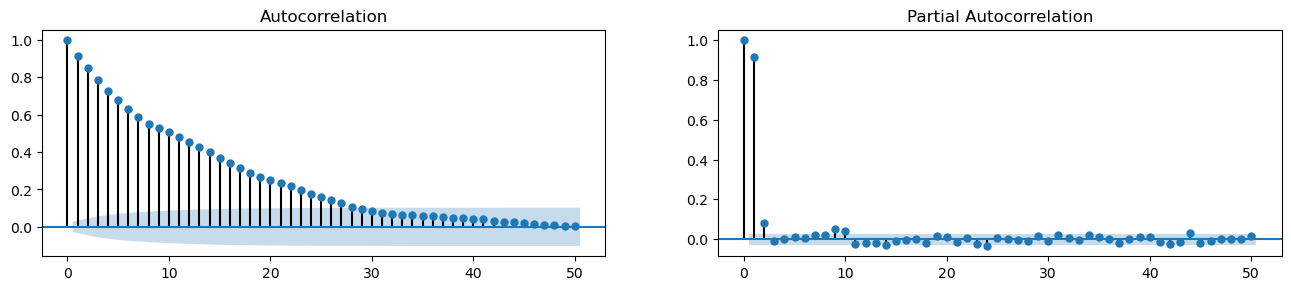

In [20]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['rsi'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['rsi'].tolist(), lags=50, ax=axes[1])

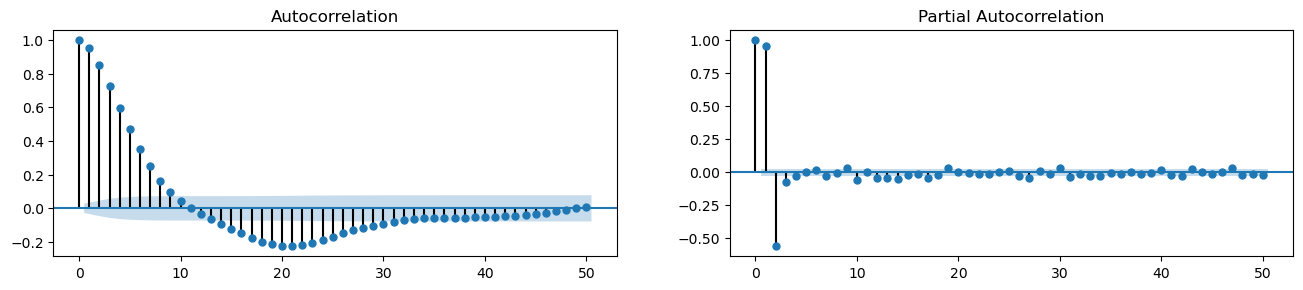

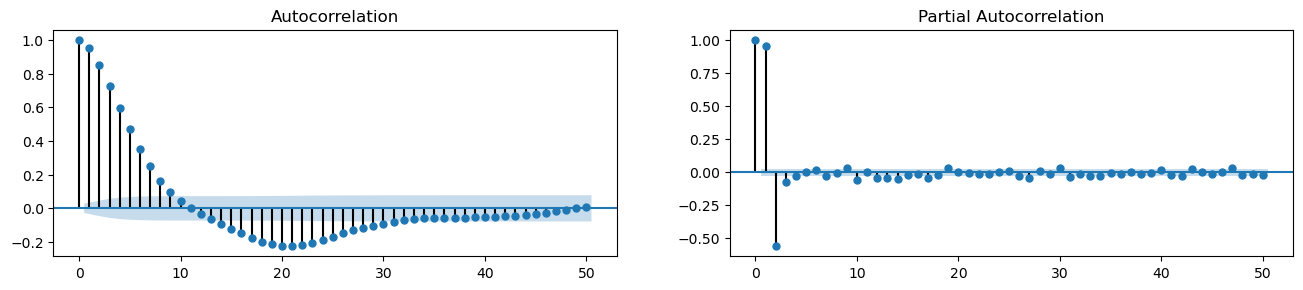

In [21]:
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['MACD_diff'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['MACD_diff'].tolist(), lags=50, ax=axes[1])

# Lag Plots
A Lag plot is a scatter plot of a time series against a lag of itself. Patterns in the plot are indications of autocorrelation. No patterns can indicate the series is white noise / random

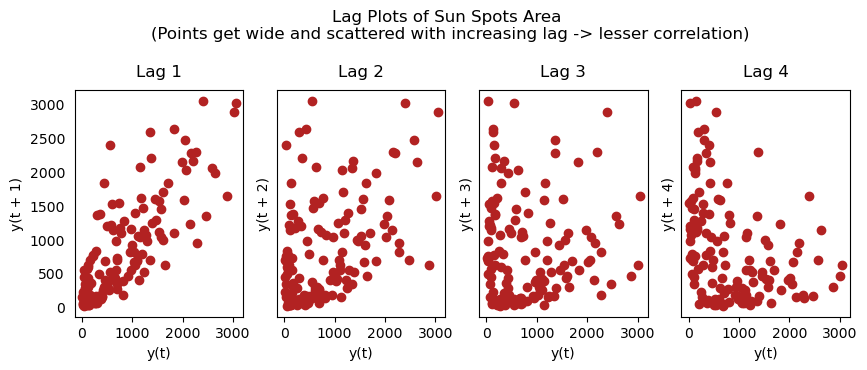

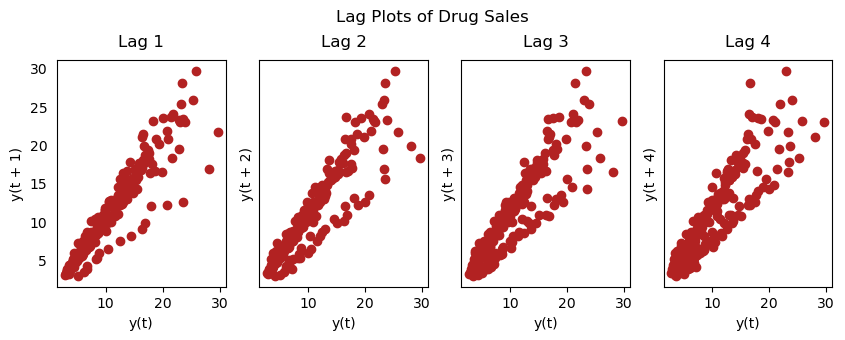

In [22]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Import
ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')
a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(ss.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Sun Spots Area \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(a10.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Drug Sales', y=1.05)    
plt.show()

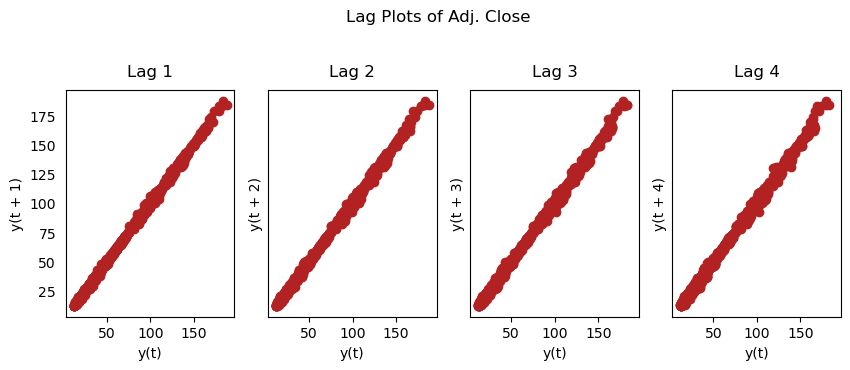

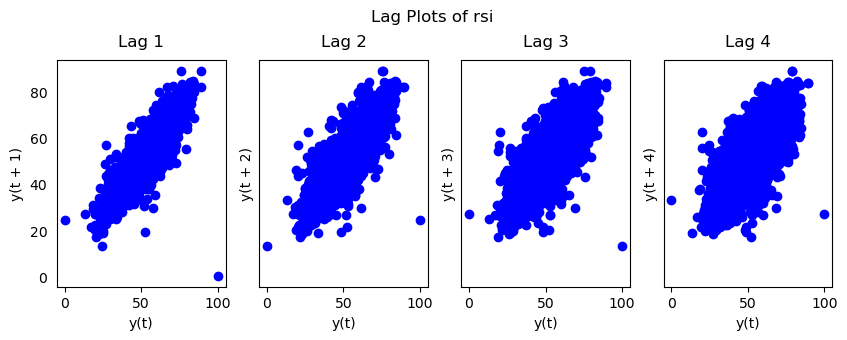

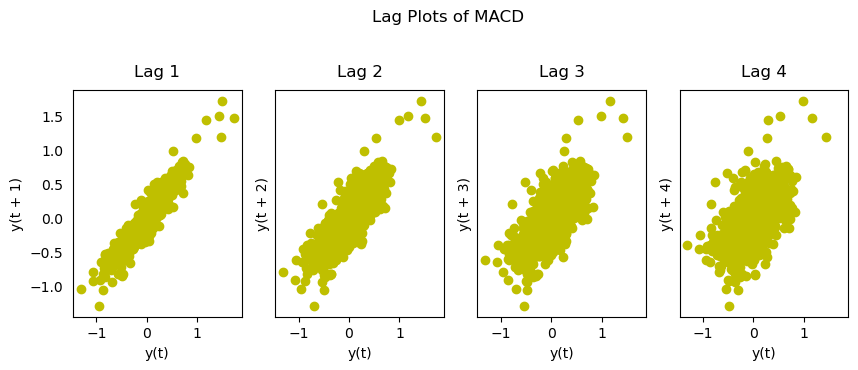

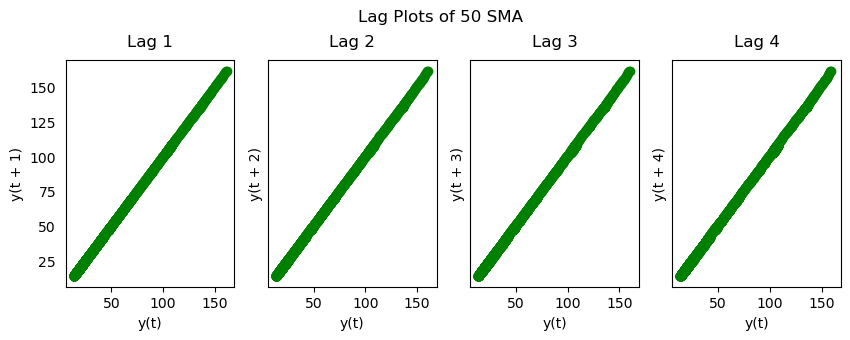

In [23]:
# lets try it for stonks
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['Adj Close'], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Adj. Close \n', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['rsi'], lag=i+1, ax=ax, c='b')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of rsi', y=1.05)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['MACD_diff'], lag=i+1, ax=ax, c='y')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of MACD', y=1.15)    

fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df['sma_50'], lag=i+1, ax=ax, c='g')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of 50 SMA', y=1.05)    
plt.show()

# Estimate the forecastability of a time series
Approximate Entropy can be used to quantify the regularity and unpredictability of fluctuations in a time series. The higher the approximate entropy, the harder it is to forecast.

Sample Entropy is similar and more consistent

In [24]:
# https://en.wikipedia.org/wiki/Approximate_entropy
ss = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/sunspotarea.csv')
a10 = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv')
rand_small = np.random.randint(0, 100, size=36)
rand_big = np.random.randint(0, 100, size=136)

def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

print(ApEn(ss.value, m=2, r=0.2*np.std(ss.value)))     # 0.651
print(ApEn(a10.value, m=2, r=0.2*np.std(a10.value)))   # 0.537
print(ApEn(rand_small, m=2, r=0.2*np.std(rand_small))) # 0.143
print(ApEn(rand_big, m=2, r=0.2*np.std(rand_big)))     # 0.716

0.6514704970333534
0.5374775224973489
0.0898376940798844
0.6725953850207098


In [25]:
# https://en.wikipedia.org/wiki/Sample_entropy
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

print(SampEn(ss.value, m=2, r=0.2*np.std(ss.value)))      # 0.78
print(SampEn(a10.value, m=2, r=0.2*np.std(a10.value)))    # 0.41
print(SampEn(rand_small, m=2, r=0.2*np.std(rand_small)))  # 1.79
print(SampEn(rand_big, m=2, r=0.2*np.std(rand_big)))      # 2.42

0.7853311366380039
0.41887013457621214
inf


/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


2.2721258855093374


# Smoothing
* Reduce the effect of noise and get an approximation of the noise-filtered series
* Visualize the trend

### 3 Methods
1. Take a moving average
2. Do a LOESS smoothing (LOcalized RegrESSion)
3. Do a LOWESS smoothing (LOcally Weighted regrESSion)

in the statsmodels package, the frac argument specifies the percentage of data points nearby that should be considered to fit a regression model


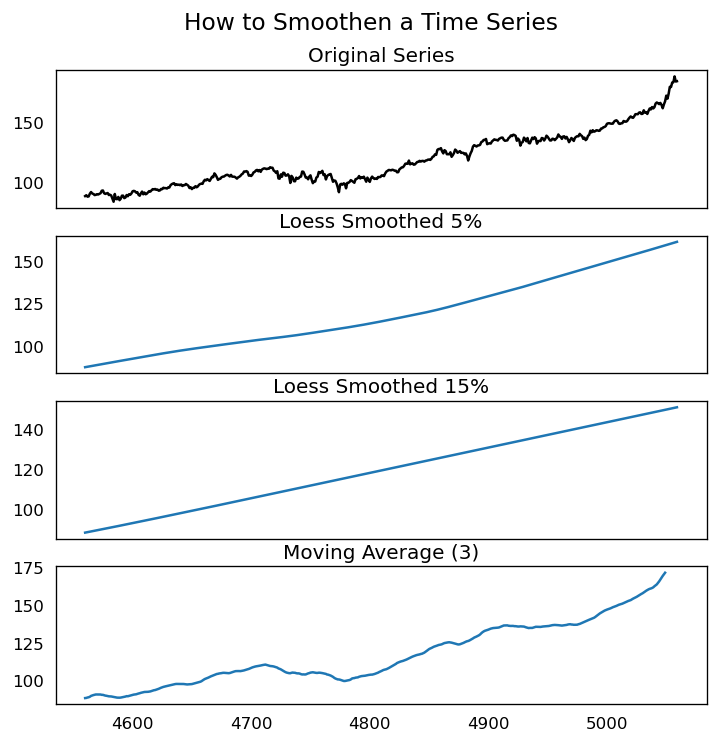

In [26]:
plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# Moving Average
df_ma = df['Adj Close'].rolling(21, center=True).mean()

# Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df['Adj Close'], np.arange(len(df['Adj Close'])), frac=0.05)[:, 1], index=df.index, columns=['Adj Close'])
df_loess_15 = pd.DataFrame(lowess(df['Adj Close'], np.arange(len(df['Adj Close'])), frac=0.15)[:, 1], index=df.index, columns=['Adj Close'])


fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df['Adj Close'].tail(500).plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['Adj Close'].tail(500).plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['Adj Close'].tail(500).plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.tail(500).plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

# Granger Causality
Used to determine if one time series will be useful to forecast another. 
If X causes Y, then the forecast of Y based on previous valies of Y and the previous values of X should outperform the forecast of Y based on previous values of Y alone.
should not be used to test if a lag of Y causes Y - generally used on exogenous variables only.
statsmodels accepts a 2D array with 2 columns as the argument: Y,X
Null Hypothesis is that the series in the second column does not Granger cause the series in the first. P-Values less then a significance level (0.05) then you reject Null Hypothesis and conclude the lag of X is useful.
Second argument maxlag tells how many lags of Y should be included in test.

In [27]:
results=grangercausalitytests(df[['Adj Close', 'Volume']], maxlag=2)
print(results)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0076  , p=0.9305  , df_denom=5056, df_num=1
ssr based chi2 test:   chi2=0.0076  , p=0.9305  , df=1
likelihood ratio test: chi2=0.0076  , p=0.9305  , df=1
parameter F test:         F=0.0076  , p=0.9305  , df_denom=5056, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0899  , p=0.9140  , df_denom=5053, df_num=2
ssr based chi2 test:   chi2=0.1800  , p=0.9139  , df=2
likelihood ratio test: chi2=0.1800  , p=0.9139  , df=2
parameter F test:         F=0.0899  , p=0.9140  , df_denom=5053, df_num=2
{1: ({'ssr_ftest': (0.007612885567819342, 0.9304747802667894, 5056.0, 1), 'ssr_chi2test': (0.007617402707198981, 0.9304507528270928, 1), 'lrtest': (0.007617396971909329, 0.9304507789431703, 1), 'params_ftest': (0.007612885341970438, 0.9304747812996946, 5056.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1294ab908>, <statsmodels.regression.linear_model.

> https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

>https://alkaline-ml.com/pmdarima/usecases/stocks.html

# Time Series Forecasting
Forecasting, for many businesses, is essential to business planning, procurement, and production

## Univariate Time Series Forecasting
Use only the previous values of a time series for prediction

## Multivariate Time Series Forecasting
Use predictors other than the series (exogenous variables)

# ARIMA
## Auto Regressive Integrated Moving Average
Class of models that explains a time series based on its own past values (its own lags) and the lagged forecast errors, so that the equation can be used to forecast future values

Any non-seasonal time series that exhibits patterns and is not random white noise can be modeled with ARIMA models

characterized by 3 terms: p, d, q

p is the oder of the AR term. It refers to the number of lags of Y to be used as predictors.

q is the order of the MA term. It refers to the number of lagged forecast errors that should go into the ARIMA model.

d is the number of differencing required to make the time series stationary. if the time series is stationary, d=0

If a time series is seasonal, you need SARIMA

## Auto Regressive
linear regression that uses its own lags as predictors. Work best when inputs are not correlated, and are independent. A pure auto regressive model is one where $Y_t$ depends only on its own lags.

$$Y_t=\alpha+\beta_1Y_{t-1}+\beta_2Y_{t-2}+...+\beta_pY_{t-p}+\epsilon_1$$

$Y_1$ is the lag1 of the series, $\beta_1$ is the coefficient of lag1 that the model estimates $\alpha$ is the intercept term also estimated by the model.

## Moving Average
A pure moving average is one where $Y_t$ depends only on the lagged forecast errors.

$$Y_t=\alpha+\epsilon_t+\phi_1\epsilon_{t-1}+\phi_2\epsilon_{t-2}+...+\phi_q\epsilon_{t-q}$$

where the error trems are the errors of the autorefressive models of the respective lags. The errors $\epsilon_t$ and $\epsilon_{t-1}$ are the errors from the following equation:

$$Y_t=\beta_1Y_{t-1}+\beta_2Y_{t-2}+...+\beta_0Y_0+\epsilon_t$$

$$Y_{t-1}=\beta_2Y_{t-2}+\beta_3Y_{t-3}+...+\beta_0Y_0+\epsilon_{t-1}$$

## put it all together -> ARIMA
The ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the aR and the MA terms. In other words, the predicted $Y_t =$ Constant + Linear Combination of Lags of Y (up to p lags) + linear combination of Lagged forecast errors (upto q lags):

$$Y_t=\alpha+\beta_1Y_{t-1}+\beta_2Y_{t-2}+...+\beta_pY_{t-p}\epsilon_t+\phi_1\epsilon_{t-1}+\phi_2\epsilon_{t-2}+...+\phi_q\epsilon_{t-q}$$

The objective is to find the values of p, d, and q.

## Find the order of differencing (d).
Differencing done to make the time series stationary.
Don't over-difference. The right order differencing is the minimum required to get a near-stationary series which roams around a defined mean and the ACF plot reaches zero fairly quick.

If the Autocorrelations are positive for many number of lags (10 or more) then the series needs further differencing. If the lag1 autocorrelation itself is too negative, then the series is probably over differenced.

go with the order that gives the least standard deviation in the differenced series.

First check for stationary with the ADF test

In [29]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['Adj Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
if result[1]>0.05:
    print('The series is not stationary')

ADF Statistic: 8.034885
p-value: 1.000000
The series is not stationary


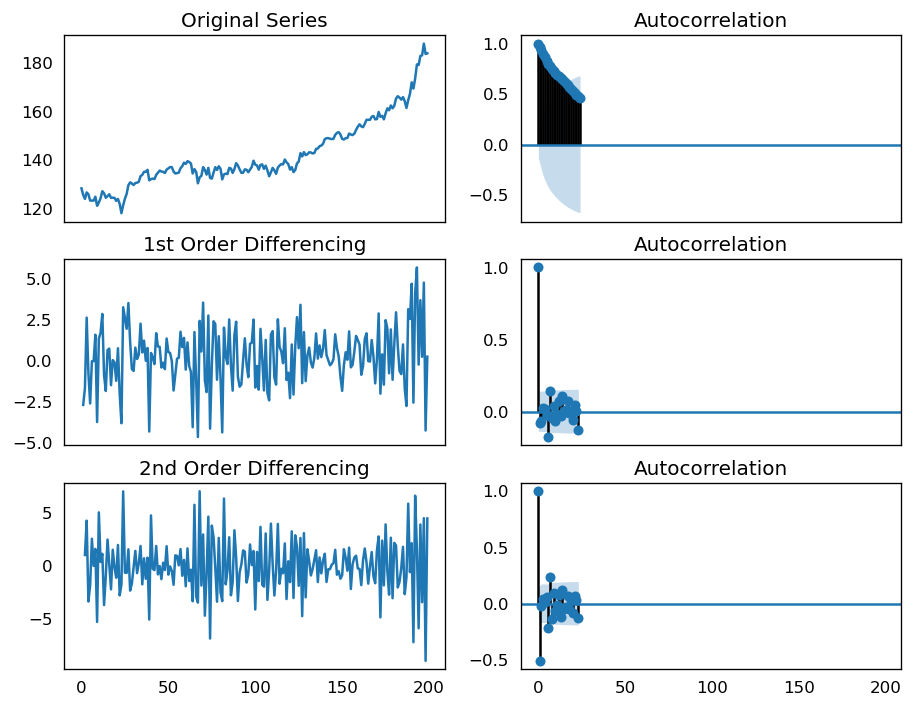

In [30]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
data = df['Adj Close'].tail(200).reset_index(drop=True)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(data); axes[0, 0].set_title('Original Series')
plot_acf(data, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data.diff().diff().dropna(), ax=axes[2, 1])

plt.show()


In [31]:
# use this fuction to estimate the value of d
# test is the type of unit root test
df_www = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
y = df_www.value

## Adf Test
x = ndiffs(y, test='adf')  # 2
print(x)
# KPSS test
x = ndiffs(y, test='kpss')  # 0
print(x)
# PP test:
x = ndiffs(y, test='pp')  # 2
print(x)

2
0
2


In [32]:
# Trying unit root test on financial data
y = df['Adj Close'].tail(200)

## Adf Test
x = ndiffs(y, test='adf')  # 2
print(x)
# KPSS test
x = ndiffs(y, test='kpss')  # 0
print(x)
# PP test:
x = ndiffs(y, test='pp')  # 2
print(x)

1
2
1


## Find the order of the AR term (p)

Find if the model needs an AR term & the order of p term is found by inspection of the Partial Autocorrelation plot (PACF)

Partial Autocorrelation can be imagined as the correlation between the seies and its lag, after exlcluding contributions from the intermediate lags

Partial Autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y:

$$Yt = \alpha_0 + \alpha_1 Y_{t-1} + \alpha_2 Y_{t-2} + \alpha_3 Y_{t-3}$$

For the above, the partial autocorrelation of lag 3 ($Y_{t-3}$) is the coefficient $\alpha_3$

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initally take the order of the AR term to be equal to as many lags that crosses the significance limit in the PACF plot. The value of p is the number of lags of the autocorrelation that are above the significance level (blue region, see below). The author will be 'conservative' and fix the value of p to 1.

/Applications/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


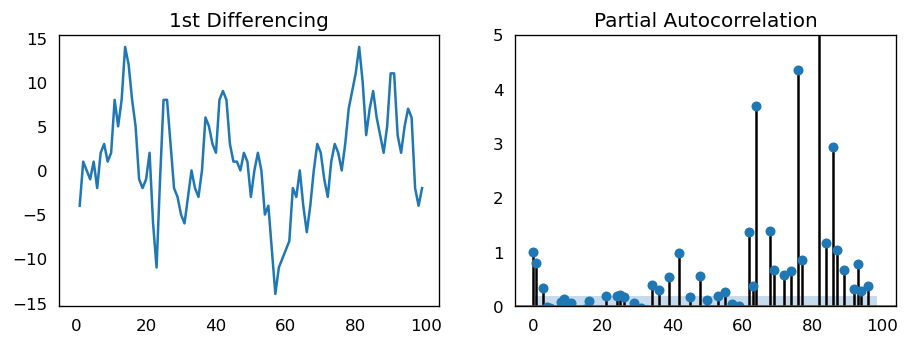

In [66]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_www.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df_www.value.diff().dropna(), ax=axes[1], lags=98)

plt.show()

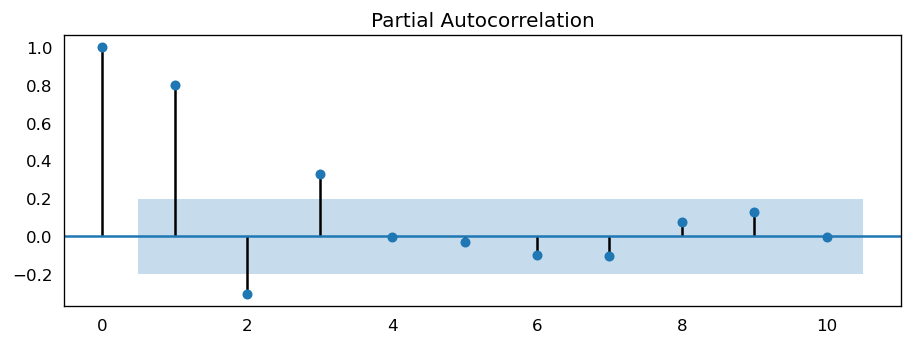

In [68]:
plot_pacf(df_www.value.diff().dropna(), lags=10)
plt.plot()     
plt.show()

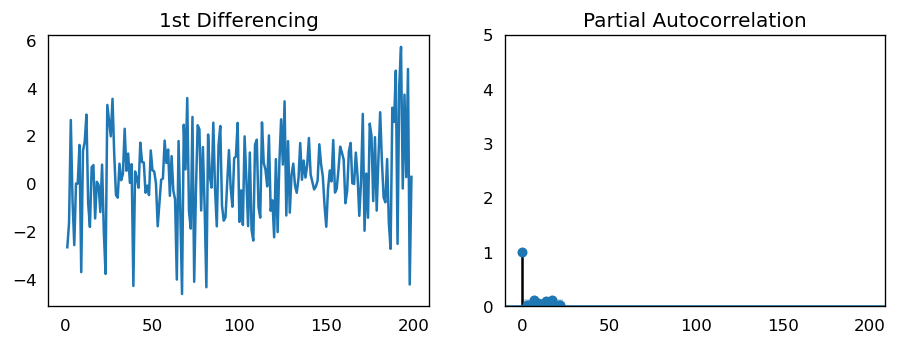

In [70]:
# PACF plot stock data
y= df.tail(200).reset_index()['Adj Close']
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(y.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(y.diff().dropna(), ax=axes[1])

plt.show()

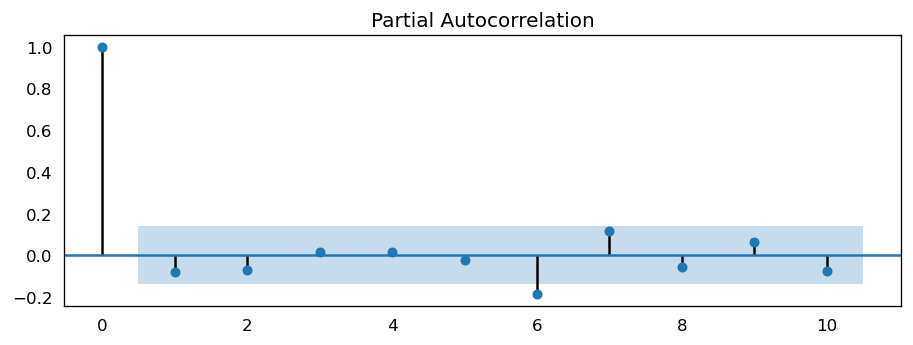

In [77]:
plot_pacf(y.diff().dropna(), lags=10)
plt.plot()     
plt.show()

## Find the order of the MA term (q)

Similar to how we looked at PACF for p, we will look at the ACF for q. A MA term is technically the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

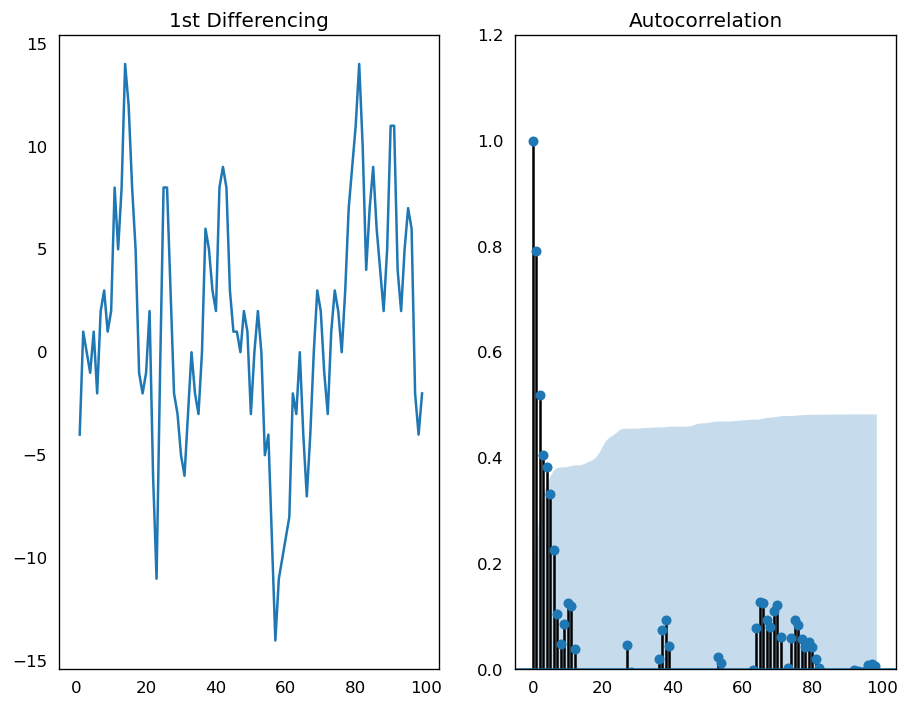

In [42]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df_www.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df_www.value.diff().dropna(), ax=axes[1], lags=98)

plt.show()

In [35]:
# with stock data

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1], lags=98)

plt.show()

It may so happen that your series is slightly under differenced, that differencing it one more time makes it slightly over-differenced.

How to handle this case?

If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.

# Build the ARIMA model
We have d, p, and q, we will use the ARIMA() implementation in statsmodels package (below). The table in the middle under coef are the weights of the respective terms. Notice the coefficient of MA2 is close to zero and the P-value in 'P>|z|' column is highly insignificant. So we try again without the MA2 term.

In [38]:
# 1,1,2 ARIMA Model
model = ARIMA(df_www.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Thu, 16 Jul 2020   AIC                            517.579
Time:                        14:11:21   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1202      1.290      0.868      0.385      -1.409       3.649
ar.L1.D.value     0.6351      0.257      2.469      0.014       0.131       1.139
ma.L1.D.value     0.5287      0.355     

In [47]:
# 1,1,1 ARIMA Model
model = ARIMA(df_www.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

# this will reduce the AIC, which is good?
# the P values have improved and are highly significant (<< 0.05)

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Thu, 16 Jul 2020   AIC                            515.579
Time:                        14:26:16   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.384      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089     

Look at plots of residual errors to ensure there are no patterns (look for constant mean and variance) I think you want them to be zero mean an have uniform variance

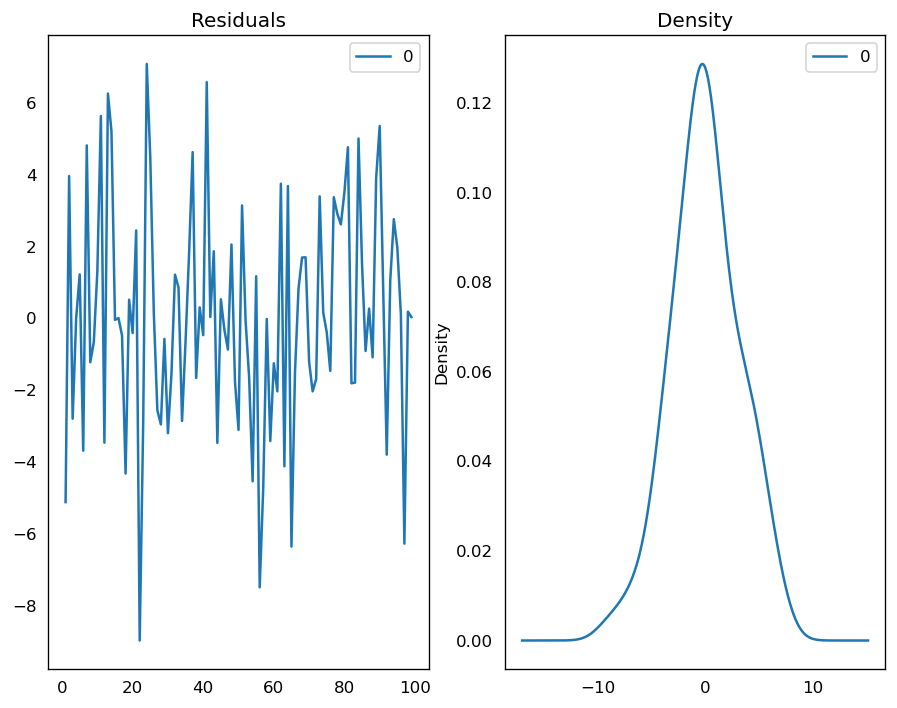

In [49]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

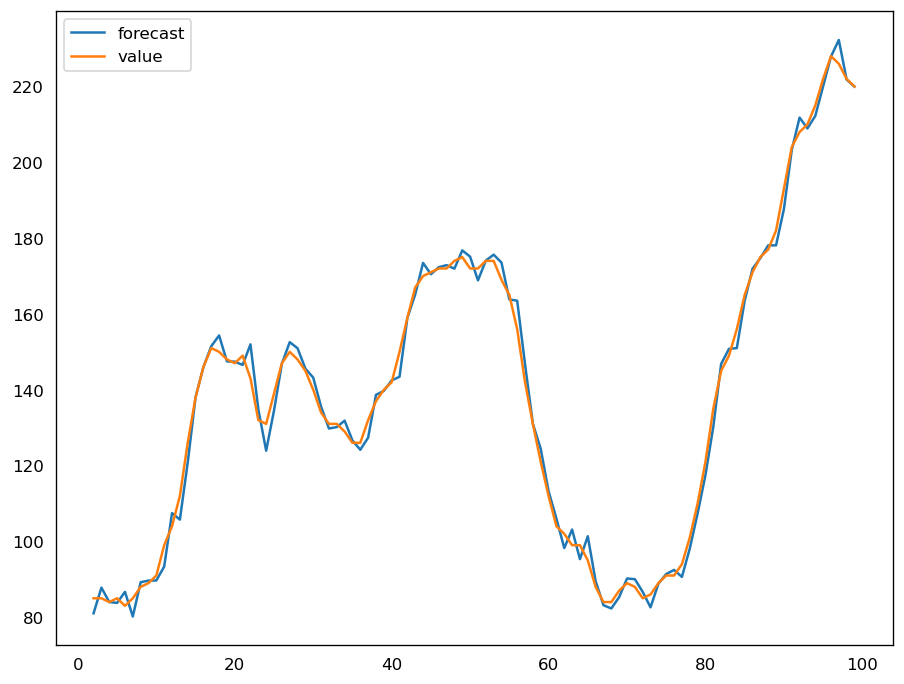

In [51]:
# plot the predicted values vs the actual
model_fit.plot_predict(dynamic=False)
plt.show()

When dynamic=False the in-sample lagged values are used for prediction. That means the model gets trained up until the previous value to make the next prediction. This can make the fitted forecast and actuals look artifically good.

# Lets try the ARIMA model above with some stock data

In [87]:
# ARIMA Model
model = ARIMA(y, order=(1,2,4)) # order = (p, d, q)
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:           D2.Adj Close   No. Observations:                  198
Model:                 ARIMA(1, 2, 4)   Log Likelihood                -393.819
Method:                       css-mle   S.D. of innovations              1.743
Date:                Thu, 16 Jul 2020   AIC                            801.637
Time:                        16:33:40   BIC                            824.655
Sample:                             2   HQIC                           810.954
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0043      0.002      2.383      0.017       0.001       0.008
ar.L1.D2.Adj Close    -0.7998      0.134     -5.970      0.000      -1.062      -0.537
ma.L1.D2.Adj Close  

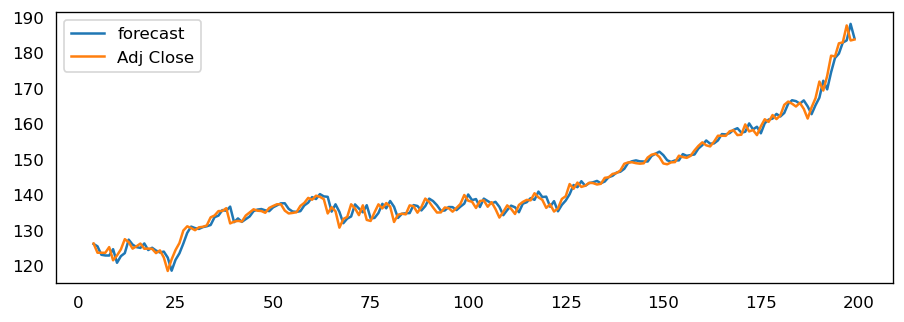

In [88]:
# plot the predicted values vs the actual
model_fit.plot_predict(dynamic=False)
plt.show()